# Denoising Autoencoder Model (Fashion MNIST)

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load and preprocess Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

# Add Gaussian noise to create noisy inputs
def add_noise(images, noise_factor=0.5):
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

x_train_noisy = add_noise(x_train)


29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [2]:
x_test_noisy = add_noise(x_test)

input_shape = (28, 28, 1)
latent_dim = 128

# Encoder
encoder_inputs = layers.Input(shape=input_shape)
x1 = layers.Conv2D(32, (3, 3), padding='same')(encoder_inputs)
x1 = layers.Activation('swish')(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(64, (3, 3), padding='same')(x1)
x1 = layers.Activation('swish')(x1)
x1 = layers.BatchNormalization()(x1)
x1_pool = layers.MaxPooling2D((2, 2), padding='same')(x1)  # 14x14x64

x2 = layers.Conv2D(128, (3, 3), padding='same')(x1_pool)
x2 = layers.Activation('swish')(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(128, (3, 3), padding='same')(x2)
x2 = layers.Activation('swish')(x2)
x2 = layers.BatchNormalization()(x2)
x2_pool = layers.MaxPooling2D((2, 2), padding='same')(x2)  # 7x7x128

x = layers.Flatten()(x2_pool)
bottleneck = layers.Dense(latent_dim, name='bottleneck')(x)
bottleneck = layers.Activation('swish')(bottleneck)

# Decoder
x = layers.Dense(7*7*128)(bottleneck)
x = layers.Activation('swish')(x)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
x = layers.Activation('swish')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.Activation('swish')(x)
x = layers.BatchNormalization()(x)

# Skip connection from x2
x = layers.Add()([x, x2])  # 14x14x128
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
x = layers.Activation('swish')(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.Activation('swish')(x)
x = layers.BatchNormalization()(x)

# Skip connection from x1
x = layers.Add()([x, x1])  # 28x28x64
x = layers.Conv2D(32, (3, 3), padding='same')(x)
x = layers.Activation('swish')(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(encoder_inputs, decoder_outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 28, 28,    │        320 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 28, 28,    │          0 │ conv2d[0][0]      │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 28, 28,    │        128 │ activation[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 28, 28,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 28, 28,    │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ activation_1[0][… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 14, 14,    │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 14, 14,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ activation_2[0][… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 14, 14,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 14, 14,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ activation_3[0][… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 6272)      │          0 │ max_pooling2d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 128)       │    802,944 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,280,001 (8.70 MB)

 Trainable params: 2,278,465 (8.69 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [3]:
# Encoder model for bottleneck visualization
encoder = models.Model(encoder_inputs, bottleneck)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 48s 66ms/step - loss: 0.0258 - val_loss: 0.0488 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - loss: 0.0130 - val_loss: 0.0121 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0121 - val_loss: 0.0128 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0117 - val_loss: 0.0182 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.0116 - val_loss: 0.0114 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0110 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0107 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0105 - val_loss: 0.0110 - learning_rate: 0.0010
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.0102 - val_loss: 0.0110 - learning_rate:

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


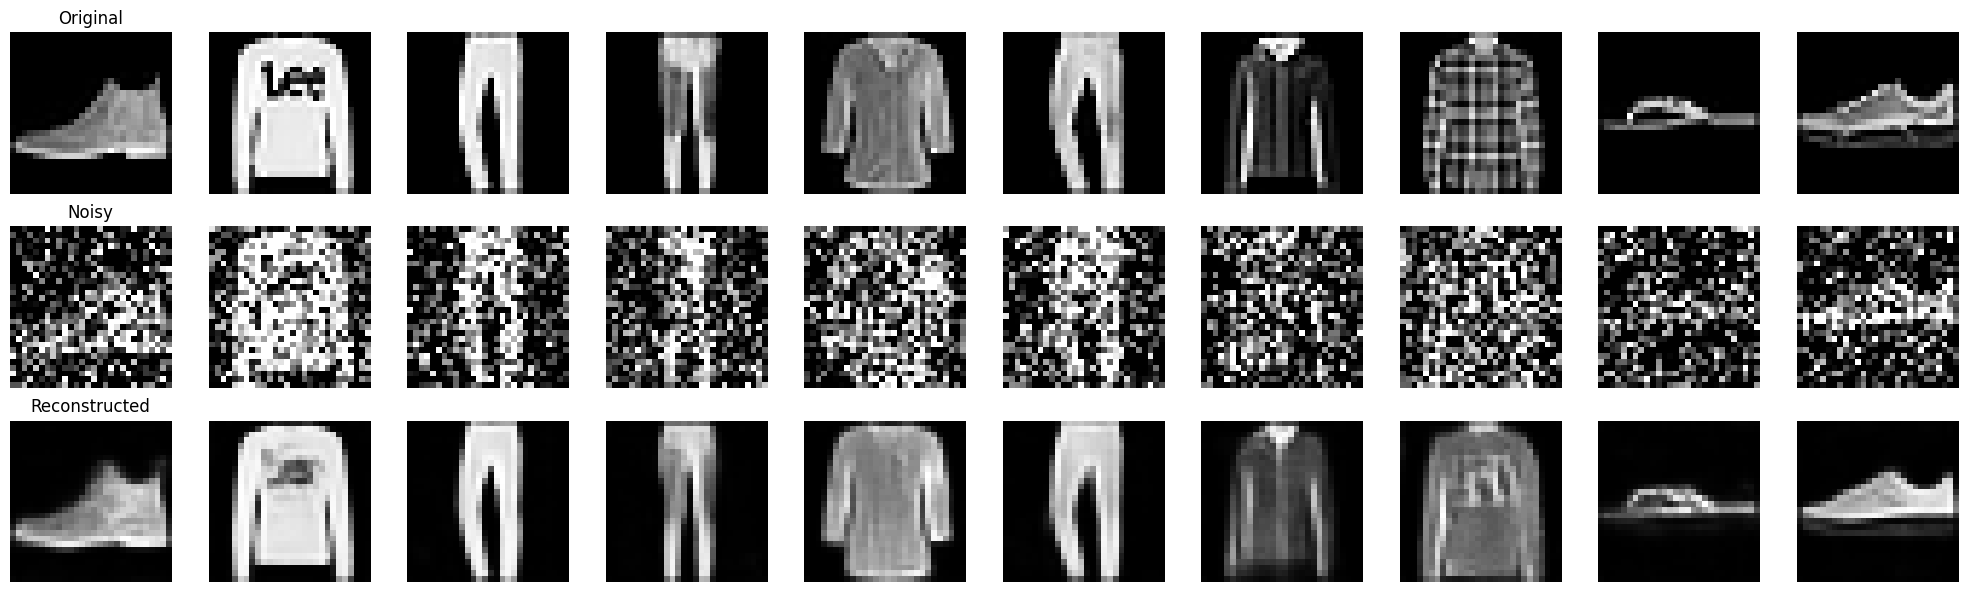

In [4]:
# Visualize original, noisy, and reconstructed images
n = 10
plt.figure(figsize=(20, 6))
decoded_imgs = autoencoder.predict(x_test_noisy[:n])

for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Original')

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Noisy')

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Reconstructed')

plt.tight_layout()
plt.show()



32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step


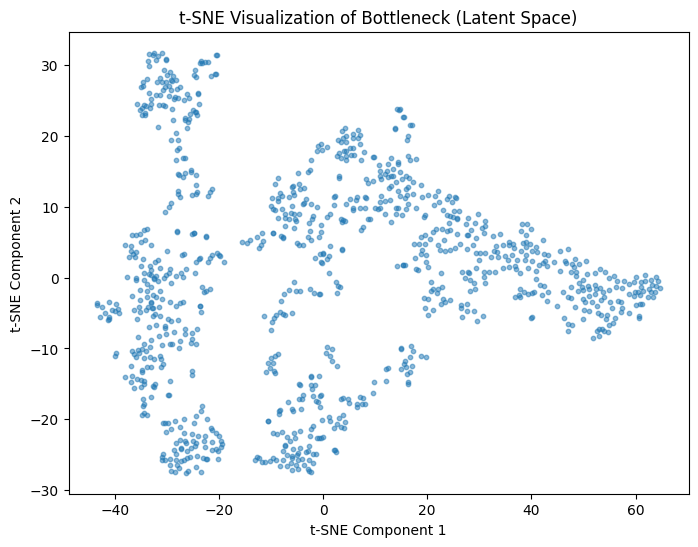

In [5]:
# Visualize bottleneck (latent space) using t-SNE
from sklearn.manifold import TSNE
latent_reps = encoder.predict(x_test[:1000])
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.5)
plt.title('t-SNE Visualization of Bottleneck (Latent Space)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig('bottleneck_visualization.png')
plt.show()



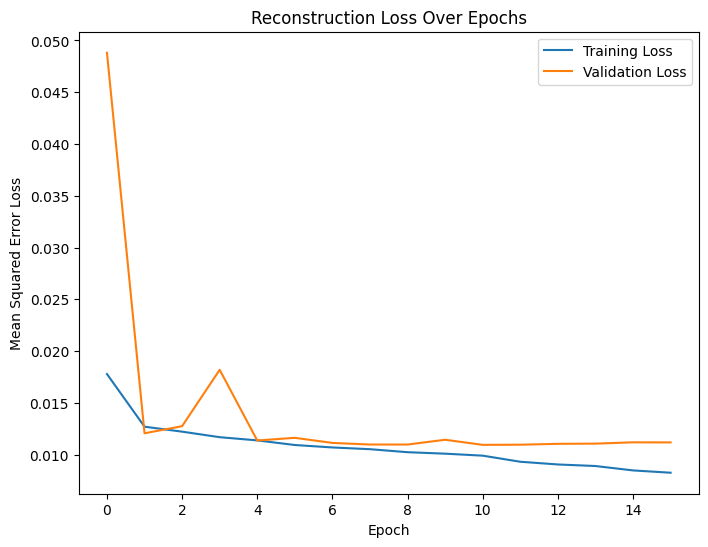

In [6]:
# Plot reconstruction loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.savefig('reconstruction_loss.png')
plt.show()

In [7]:
# Encoder
encoder_inputs = layers.Input(shape=input_shape)
x1 = layers.Conv2D(32, (3, 3), padding='same')(encoder_inputs)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(64, (3, 3), padding='same')(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.BatchNormalization()(x1)
x1_pool = layers.MaxPooling2D((2, 2), padding='same')(x1)  # 14x14x64

x2 = layers.Conv2D(128, (3, 3), padding='same')(x1_pool)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(128, (3, 3), padding='same')(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.BatchNormalization()(x2)
x2_pool = layers.MaxPooling2D((2, 2), padding='same')(x2)  # 7x7x128

x = layers.Flatten()(x2_pool)
bottleneck = layers.Dense(latent_dim, name='bottleneck')(x)
bottleneck = layers.LeakyReLU(alpha=0.1)(bottleneck)

# Decoder
x = layers.Dense(7*7*128)(bottleneck)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(128, (3, 3), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)

# Skip connection from x2
x = layers.Add()([x, x2])  # 14x14x128
x = layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)

# Skip connection from x1
x = layers.Add()([x, x1])  # 28x28x64
x = layers.Conv2D(32, (3, 3), padding='same')(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(encoder_inputs, decoder_outputs)
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 28, 28,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu         │ (None, 28, 28,    │          0 │ conv2d_8[0][0]    │
│ (LeakyReLU)         │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ leaky_re_lu[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 28, 28,    │     18,496 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_1       │ (None, 28, 28,    │          0 │ conv2d_9[0][0]    │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ leaky_re_lu_1[0]… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 14, 14,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 14, 14,    │          0 │ conv2d_10[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ leaky_re_lu_2[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 14, 14,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_3       │ (None, 14, 14,    │          0 │ conv2d_11[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ leaky_re_lu_3[0]… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 6272)      │          0 │ max_pooling2d_3[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 128)       │    802,944 │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,280,001 (8.70 MB)

 Trainable params: 2,278,465 (8.69 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [9]:
# Encoder model for bottleneck visualization
encoder = models.Model(encoder_inputs, bottleneck)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)



Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 35s 59ms/step - loss: 0.0267 - val_loss: 0.0465 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 28s 42ms/step - loss: 0.0137 - val_loss: 0.0127 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - loss: 0.0124 - val_loss: 0.0118 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0117 - val_loss: 0.0116 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0112 - val_loss: 0.0115 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0108 - val_loss: 0.0112 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0106 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - loss: 0.0104 - val_loss: 0.0111 - learning_rate: 0.0010
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - loss: 0.0101 - val_loss: 0.0109 - learning_rate:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 762ms/step


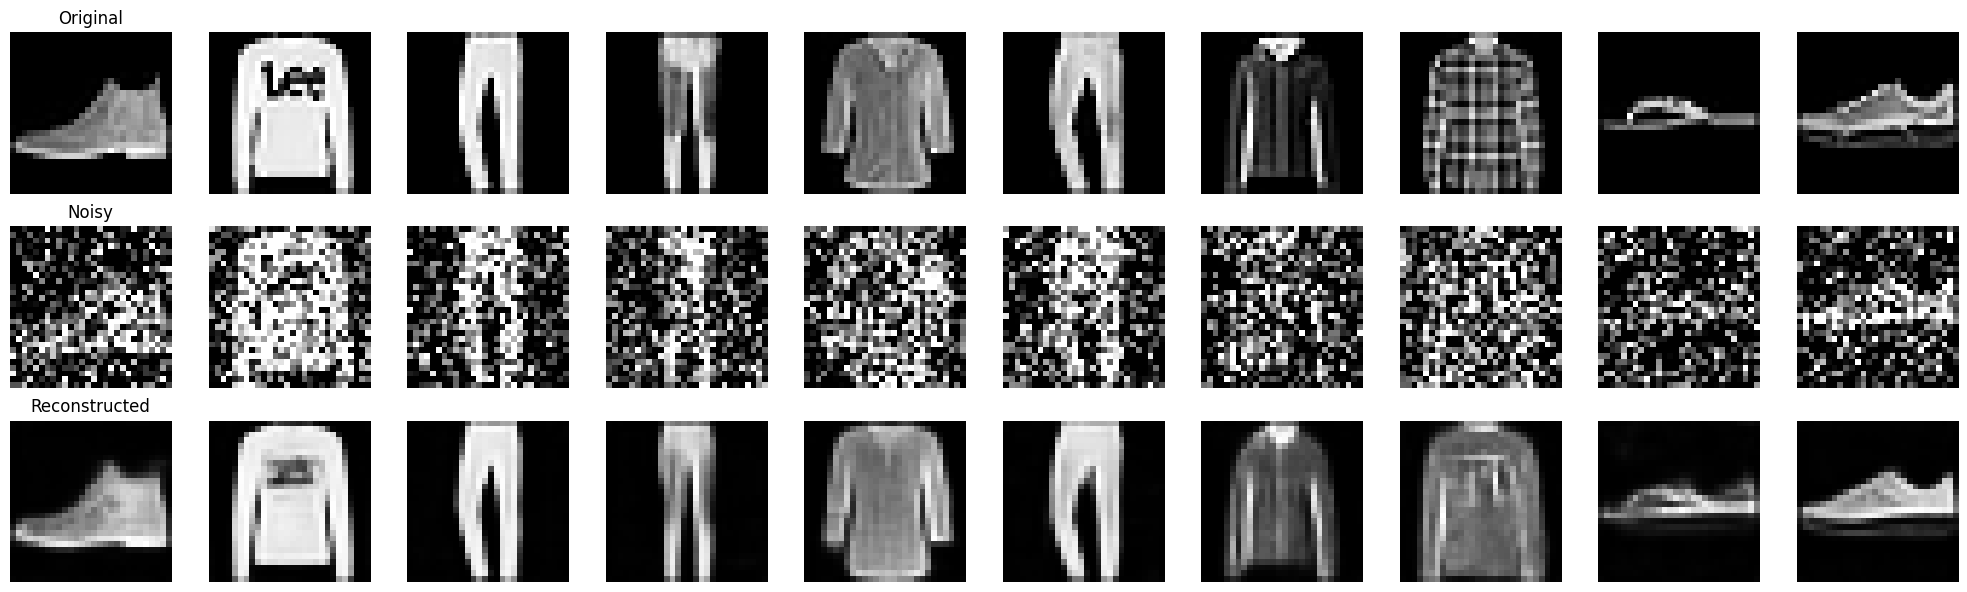

In [10]:
# Visualize original, noisy, and reconstructed images
n = 10
plt.figure(figsize=(20, 6))
decoded_imgs = autoencoder.predict(x_test_noisy[:n])

for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Original')

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Noisy')

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Reconstructed')

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step


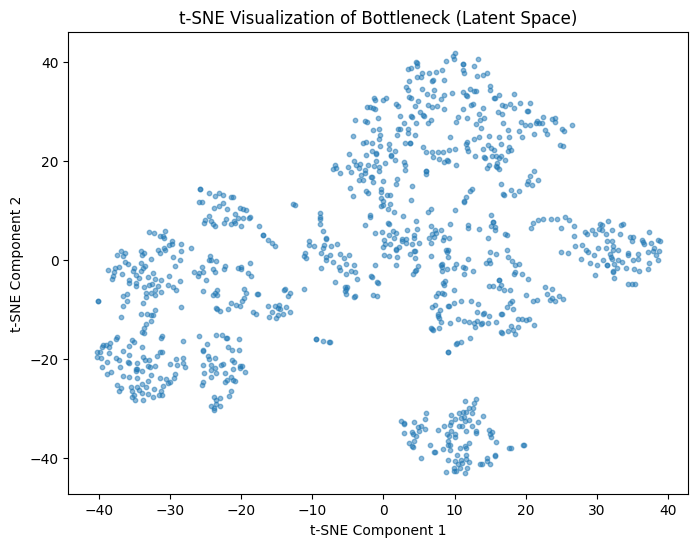

In [11]:
# Visualize bottleneck (latent space) using t-SNE
latent_reps = encoder.predict(x_test[:1000])
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.5)
plt.title('t-SNE Visualization of Bottleneck (Latent Space)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig('bottleneck_visualization.png')
plt.show()



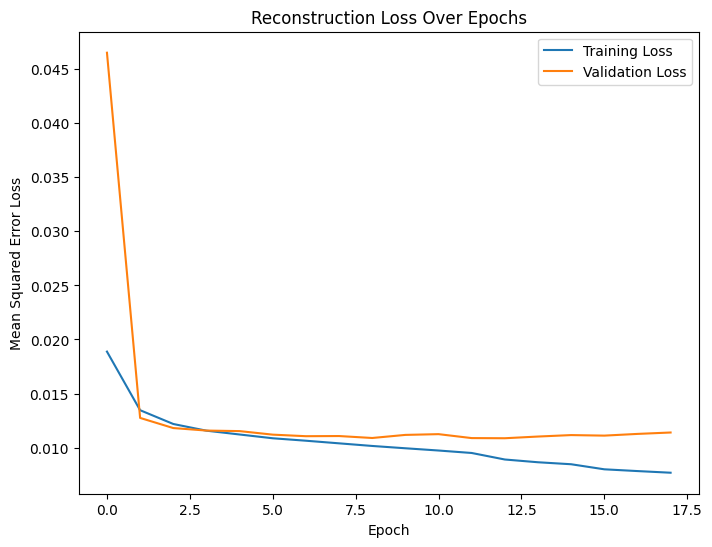

In [12]:
# Plot reconstruction loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error Loss')
plt.legend()
plt.savefig('reconstruction_loss.png')
plt.show()

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.manifold import TSNE
from tensorflow.image import ssim


In [29]:

# Custom PixelShuffler layer
class PixelShuffler(layers.Layer):
    def __init__(self, scale_factor, **kwargs):
        super(PixelShuffler, self).__init__(**kwargs)
        self.scale_factor = scale_factor

    def call(self, inputs):
        return tf.nn.depth_to_space(inputs, self.scale_factor)

    def compute_output_shape(self, input_shape):
        batch, height, width, channels = input_shape
        new_height = height * self.scale_factor if height is not None else None
        new_width = width * self.scale_factor if width is not None else None
        new_channels = channels // (self.scale_factor ** 2) if channels is not None else None
        return (batch, new_height, new_width, new_channels)

# Custom SSIM + MSE loss
def combined_loss(y_true, y_pred):
    mse_loss = tf.keras.losses.MeanSquaredError()(y_true, y_pred)
    ssim_loss = 1 - tf.reduce_mean(ssim(y_true, y_pred, max_val=1.0))
    return mse_loss + 0.5 * ssim_loss  # Balance MSE and SSIM

# Load and preprocess Fashion MNIST dataset
(x_train, _), (x_test, _) = fashion_mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

# Add Gaussian noise to create noisy inputs
def add_noise(images, noise_factor=0.4):  # Reduced noise factor
    noise = np.random.normal(loc=0.0, scale=noise_factor, size=images.shape)
    noisy_images = images + noise
    noisy_images = np.clip(noisy_images, 0., 1.)
    return noisy_images

x_train_noisy = add_noise(x_train)
x_test_noisy = add_noise(x_test)


In [31]:

# Define the Autoencoder model
input_shape = (28, 28, 1)
latent_dim = 96

# Encoder
encoder_inputs = layers.Input(shape=input_shape)
x1 = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(encoder_inputs)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.BatchNormalization()(x1)
x1 = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x1)
x1 = layers.LeakyReLU(alpha=0.1)(x1)
x1 = layers.BatchNormalization()(x1)
x1_pool = layers.MaxPooling2D((2, 2), padding='same')(x1)  # 14x14x64

x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x1_pool)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.BatchNormalization()(x2)
x2 = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x2)
x2 = layers.LeakyReLU(alpha=0.1)(x2)
x2 = layers.BatchNormalization()(x2)
x2_pool = layers.MaxPooling2D((2, 2), padding='same')(x2)  # 7x7x128

x = layers.Flatten()(x2_pool)
bottleneck = layers.Dense(latent_dim, name='bottleneck', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
bottleneck = layers.LeakyReLU(alpha=0.1)(bottleneck)

# Decoder
x = layers.Dense(7*7*128)(bottleneck)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.Reshape((7, 7, 128))(x)
x = layers.Conv2D(512, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)  # 4x channels for PixelShuffler
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = PixelShuffler(scale_factor=2)(x)  # PixelShuffler: 14x14x128
x = layers.Conv2D(128, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, x2])  # Skip connection

x = layers.Conv2D(256, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)  # 4x channels for PixelShuffler
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = PixelShuffler(scale_factor=2)(x)  # PixelShuffler: 28x28x64
x = layers.Conv2D(64, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
x = layers.Add()([x, x1])  # Skip connection

x = layers.Conv2D(32, (3, 3), padding='same', kernel_regularizer=tf.keras.regularizers.l2(1e-4))(x)
x = layers.LeakyReLU(alpha=0.1)(x)
x = layers.BatchNormalization()(x)
decoder_outputs = layers.Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

# Autoencoder model
autoencoder = models.Model(encoder_inputs, decoder_outputs)
autoencoder.compile(optimizer='adam', loss=combined_loss)
autoencoder.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 28, 28,    │        640 │ input_layer_6[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_47      │ (None, 28, 28,    │          0 │ conv2d_46[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ leaky_re_lu_47[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 28, 28,    │     36,928 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_48      │ (None, 28, 28,    │          0 │ conv2d_47[0][0]   │
│ (LeakyReLU)         │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        256 │ leaky_re_lu_48[0… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 14, 14,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_48 (Conv2D)  │ (None, 14, 14,    │     73,856 │ max_pooling2d_12… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_49      │ (None, 14, 14,    │          0 │ conv2d_48[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ leaky_re_lu_49[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_49 (Conv2D)  │ (None, 14, 14,    │    147,584 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_50      │ (None, 14, 14,    │          0 │ conv2d_49[0][0]   │
│ (LeakyReLU)         │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 14, 14,    │        512 │ leaky_re_lu_50[0… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_13    │ (None, 7, 7, 128) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_6 (Flatten) │ (None, 6272)      │          0 │ max_pooling2d_13… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bottleneck (Dense)  │ (None, 96)        │    602,208 │ flatten_6[0][0]   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,563,873 (9.78 MB)

 Trainable params: 2,561,121 (9.77 MB)

 Non-trainable params: 2,752 (10.75 KB)

In [32]:

# Encoder model for bottleneck visualization
encoder = models.Model(encoder_inputs, bottleneck)

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

# Train the model
history = autoencoder.fit(
    x_train_noisy, x_train,
    epochs=50,
    batch_size=128,
    validation_data=(x_test_noisy, x_test),
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 47s 70ms/step - loss: 0.2629 - val_loss: 0.3485 - learning_rate: 0.0010
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.1730 - val_loss: 0.1850 - learning_rate: 0.0010
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 46ms/step - loss: 0.1538 - val_loss: 0.3249 - learning_rate: 0.0010
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 0.1582 - val_loss: 0.1517 - learning_rate: 0.0010
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 47ms/step - loss: 0.1465 - val_loss: 0.1522 - learning_rate: 0.0010
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.1433 - val_loss: 0.1532 - learning_rate: 0.0010
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 47ms/step - loss: 0.1413 - val_loss: 0.1433 - learning_rate: 0.0010
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 41s 48ms/step - loss: 0.1412 - val_loss: 0.1439 - learning_rate: 0.0010
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 23s 48ms/step - loss: 0.1553 - val_loss: 0.1543 - learning_rate:

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


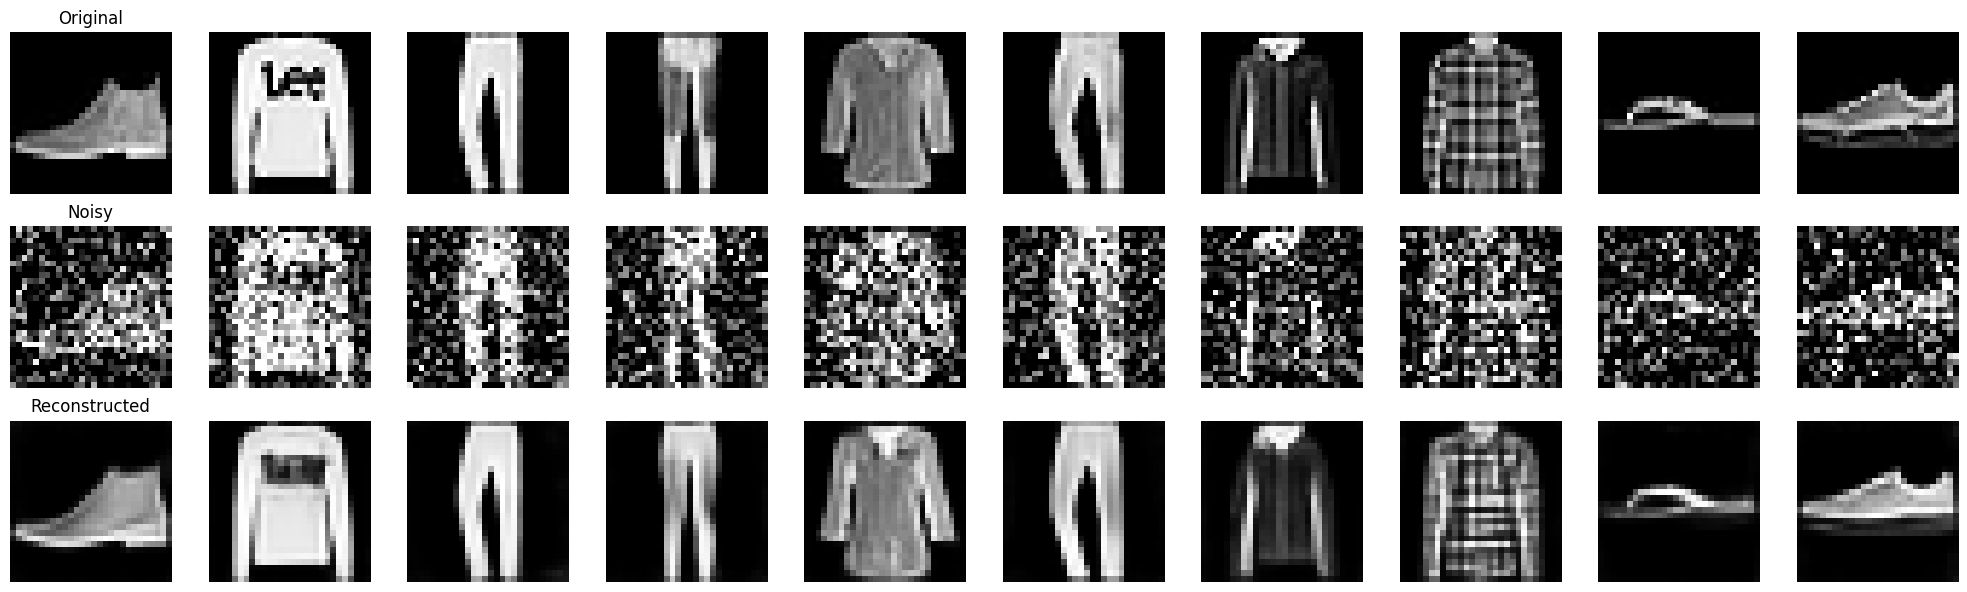

In [33]:
# Visualize original, noisy, and reconstructed images
n = 10
plt.figure(figsize=(20, 6))
decoded_imgs = autoencoder.predict(x_test_noisy[:n])

for i in range(n):
    # Original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Original')

    # Noisy
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Noisy')

    # Reconstructed
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
    if i == 0:
        ax.set_title('Reconstructed')

plt.tight_layout()
plt.show()


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step


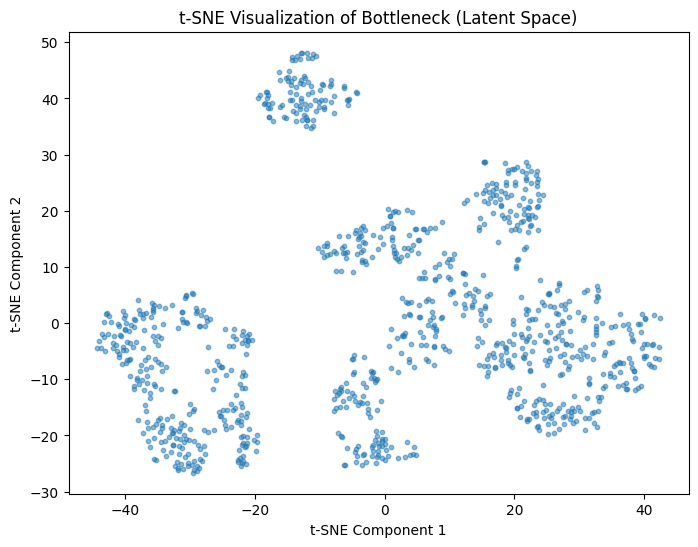

In [34]:

# Visualize bottleneck (latent space) using t-SNE
latent_reps = encoder.predict(x_test[:1000])
tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(latent_reps)

plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], s=10, alpha=0.5)
plt.title('t-SNE Visualization of Bottleneck (Latent Space)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.savefig('bottleneck_visualization.png')
plt.show()


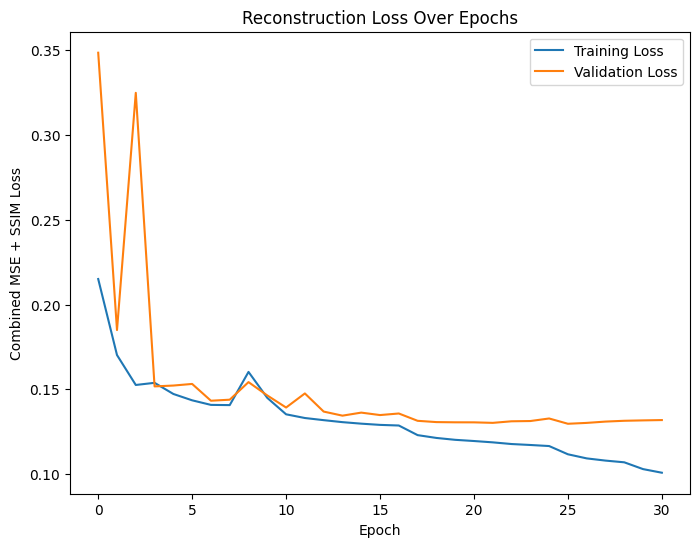

In [35]:

# Plot reconstruction loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Reconstruction Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Combined MSE + SSIM Loss')
plt.legend()
plt.savefig('reconstruction_loss.png')
plt.show()


#  Denoising Autoencoder Model Comparison (Fashion MNIST)

This report compares three denoising autoencoders trained on Fashion MNIST to reconstruct clean images from noisy inputs. Models differ in architecture, activation, upscaling, and loss strategies.



##  Model Architectures

| Feature          | **Model-1**      | **Model-2**      | **Model-3**              |
| ---------------- | ---------------- | ---------------- | ------------------------ |
| Activation       | Swish            | LeakyReLU (0.1)  | LeakyReLU (0.1)          |
| Latent Dim       | 128              | 128              | 96                       |
| Upscaling        | Conv2DTranspose  | Conv2DTranspose  | **PixelShuffler**        |
| Skip Connections | ✅ (14x14, 28x28) | ✅ (14x14, 28x28) | ✅ (14x14, 28x28)         |
| Loss Function    | MSE              | MSE              | **MSE + 0.5×(1 - SSIM)** |
| Regularization   | ❌                | ❌                | **L2 (1e-4)**            |
| Noise Factor     | 0.5              | 0.5              | **0.4**                  |


##  Training Performance

| Metric           | **Model-1** | **Model-2** | **Model-3**             |
| ---------------- | ----------- | ----------- | ----------------------- |
| Epochs Trained   | 16          | 18          | **31**                  |
| Best Val Loss    | 0.0110      | 0.0109      | **0.1297** *(MSE+SSIM)* |
| Final Train Loss | 0.0082      | 0.0076      | 0.1003                  |
| LR Reduced To    | 2.5e-4      | 2.5e-4      | **6.25e-5**             |

*Note: Model-3’s higher val\_loss includes SSIM and isn't directly comparable to MSE-only models.*


##  Reconstruction Quality (Inferred)

* **Model-1**: Good feature capture with Swish; blurriness from Conv2DTranspose; no regularization.
* **Model-2**: Slightly sharper than Model-1; same issues due to similar architecture.
* **Model-3**: Best perceptual quality due to:

  * **PixelShuffler** (no checkerboard artifacts)
  * **SSIM loss** (sharp structure)
  * **Regularization** and lower noise
  * Larger encoder filters

##  Why Model-3 is Superior

* PixelShuffler improves smoothness in upscaling.
* Combined MSE + SSIM loss targets both accuracy and structure.
* L2 regularization boosts generalization.
* Lower noise factor enhances detail recovery.
* Higher encoder capacity extracts richer features.

##  Conclusion

**Model-3** is best for perceptual clarity and structural fidelity. Despite higher numerical loss, its innovations in upscaling, loss design, and regularization make it more robust for denoising tasks.
